# Parallel: Batch Data Fitting Example

In large scale applications, it is often required to fit a single model to multiple datasets. This example demonstrates how to use the `batch_data_fit` function from the `nleis.parallel` module to perform batch fitting of a model to different datasets in parallel.
The `batch_data_fit` function allows you to specify a list of datasets and fits the same model to each dataset using multiple CPU cores, significantly speeding up the fitting process once a resonable model is established. Same as `multistart_fit`, the `batch_data_fit` is also compatible with impedance.py natively. For detailed documentation, please refer to the [API reference](https://nleispy.readthedocs.io/en/latest/).

For simplicity and readability, we demonstrate this functionality by generating a batch of synthetic EIS data using a porous electrode model and fitting it with the 3-RC ECM. The same procedure can be applied to simultaneous EIS
and 2nd-NLEIS data using a `EISandNLEIS` function with `batch_data_fit` function to fit the model to multiple noisy datasets.

In this example, we are generating a total of 20 datasets with different different parameters and random distrubuted noise.

In [2]:
import numpy as np
np.random.seed(0)  # For reproducibility
import matplotlib.pyplot as plt
from impedance.models.circuits import CustomCircuit
from nleis.visualization import plot_first

f = np.geomspace(1e-3, 100, 50)

circuit_1 = "TP0"
num_samples = 20
initial_guesses = np.random.uniform(low=1e-2, high=10, size=(
            num_samples, 3))*np.array([1, 1, 1])
model_1 = CustomCircuit(circuit_1, initial_guess=[1, 1,1])

Z_data =[]
for i in range(num_samples):
    model_1.initial_guess = initial_guesses[i]
    model_1.predict
    Z1 = model_1.predict(f)
    Z1_noise = Z1 + 0.01*(np.random.randn(len(Z1)) + 1j*np.random.randn(len(Z1)))
    Z_data.append(Z1_noise)

We can now import `batch_data_fit` from `nleis.parallel` module. Then we can use it to fit the model to the generated datasets in parallel.

In [3]:
from nleis.parallel import batch_data_fit

After model initialization, we can call the `batch_data_fit` function to fit the model to the generated datasets. Here, we specify `n_jobs=-1` to use all available CPU cores for parallel processing.

For this example, since we are only fitting EIS data, we only need to provide the `impedance_list` argument with the list of generated impedance datasets. If fitting both EIS and 2nd-NLEIS data, both `Z1_list` and `Z2_list` arguments need to be provided.

In [4]:
model = CustomCircuit('p(R1,C1)-p(R2,C2)-p(R3,C3)',initial_guess=[1,1,1,1,1,1])

results = batch_data_fit(model, f, impedance_list=Z_data, n_jobs=-1, backend="loky", batch_size="auto")


{'idx': 0, 'Status': True, 'p0': [1, 1, 1, 1, 1, 1], 'p': array([1.26757063, 1.74102024, 0.4021791 , 0.21849642, 7.20629131,
       5.90937679]), 'cost': 0.001990633464336123, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x111acc990>}
{'idx': 1, 'Status': True, 'p0': [1, 1, 1, 1, 1, 1], 'p': array([1.18393753, 1.82693623, 4.32857365, 6.1789902 , 0.39682292,
       0.2516461 ]), 'cost': 0.003686339176608891, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x1141d3910>}
{'idx': 3, 'Status': True, 'p0': [1, 1, 1, 1, 1, 1], 'p': array([0.90119775, 1.66307277, 0.3090964 , 0.23522692, 7.93973648,
       5.25545609]), 'cost': 0.0009842013189212604, 'model': <impedance.models.circuits.circuits.CustomCircuit object at 0x1136e1390>}
{'idx': 2, 'Status': True, 'p0': [1, 1, 1, 1, 1, 1], 'p': array([8.9409488 , 9.5158982 , 1.04317291, 2.82959363, 0.32352904,
       0.34234691]), 'cost': 0.001180389782236264, 'model': <impedance.models.circuits.circuits.C

After fitting, we can visualize the fitting results for each dataset by plotting the original data and the fitted model. For demonstration purposes, we will only plot the first two datasets.

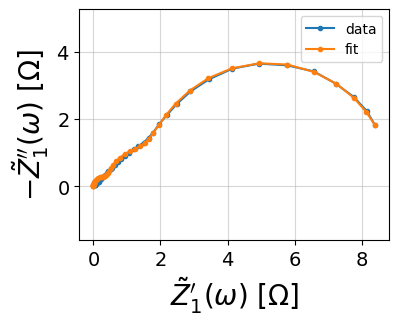

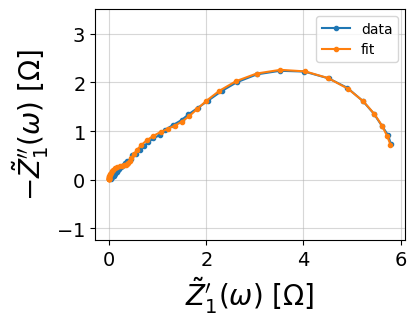

In [5]:
for i in range(2):
    fig, ax = plt.subplots(figsize=(4,3))
    plot_first(ax, Z_data[i])
    Z_fit = results[i]['model'].predict(f)
    plot_first(ax, Z_fit)
    ax.legend(['data','fit'])
    plt.show()


we can also print out the fitting results for each dataset, such as the optimized parameters. Here we use the `tabulate` library to format the output in a table for better readability. Now, we can effectively compare the variation of fitted parameters across multiple datasets or measurements.

After fitting, users can easily customize the output format and post-process the results as needed.

In [6]:
from tabulate import tabulate

In [7]:
Headers = ['R1', 'C1', 'R2', 'C2', 'R3', 'C3']
table = [] 
for i in range(len(Z_data)):
    row = [np.round(results[i]['p'][j],4) for j in range(6)]
    table.append(row)
print(tabulate(table,headers=Headers, tablefmt='plain'))


    R1      C1      R2      C2      R3      C3
1.2676  1.741   0.4022  0.2185  7.2063  5.9094
1.1839  1.8269  4.3286  6.179   0.3968  0.2516
8.9409  9.5159  1.0432  2.8296  0.3235  0.3423
0.9012  1.6631  0.3091  0.2352  7.9397  5.2555
1.3337  0.2141  9.3079  0.7109  0.4327  0.0279
0.2873  4.7861  0.1225  1.4504  0.034   0.1987
1.7738  2.7741  8.7728  9.5121  0.5585  0.35
4.8378  7.0318  1.637   1.965   0.5127  0.2515
0.2943  0.4188  6.4065  1.436   0.0853  0.0544
5.4612  3.784   1.93    1.0863  0.6371  0.1429
7.756   4.5481  0.6351  1.4499  0.2139  0.2
0.2738  0.3921  0.697   1.2139  0.0902  0.0459
6.2547  9.1326  1.3807  2.6461  0.4381  0.3428
3.7873  3.9489  0.4509  0.1436  1.3835  1.1279
1.3612  2.0746  0.5149  0.7063  0.1855  0.0894
0.3763  0.0367  1.1317  0.2851  2.469   0.9834
0.2242  0.1821  0.7257  1.6108  3.6844  5.5477
1.0462  0.3228  9.909   1.0237  0.3513  0.0442
0.1558  0.2418  0.4606  1.9379  1.6497  6.3499
4.6843  2.4205  0.1823  0.0856  0.6124  0.7116
